In [1]:
# import

from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.functional as F
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR



In [2]:
# Modelling options for the loop


d1 = {'NO L1&L1': [0.,0.,'model'],
      'L1 Only': [1e-04,0.,'model'], 
      'L2 Only': [0.,1e-04,'model'],
      'L1&L2':[1e-04,1e-04,'model'],
      'GBN Only': [0,0,'model2'],
      'GBN with L1 and L2':[1e-04,1e-04,'model2']}

#initializers 
dropout_value = 0.05
num_splits=2
EPOCHS = 25

metric_values = {}
models={}




In [3]:
# Transforms

train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,),(0.3081,))
                                       ])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),(0.3081,))
                                      ])


In [4]:
# download data
train = datasets.MNIST('./data',train=True,transform=train_transforms, download=True)
test = datasets.MNIST('./data',train=False, transform =test_transforms, download=True)

In [5]:
# Data loader
SEED=1
cuda = torch.cuda.is_available()

# torch.manual_seed(SEED)

# if cuda:
#   torch.cuda.manual_seed(SEED)

torch.cuda.manual_seed(SEED) if cuda else torch.manual_seed(SEED)

dataloader_args=dict(shuffle=True,batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# Train loader
train_loader = torch.utils.data.DataLoader(train,**dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


torch.Size([128, 1, 28, 28]) torch.Size([1, 28, 28])
(28, 28)


Text(0.5, 1.0, '4')

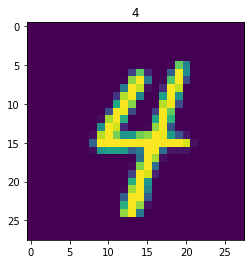

In [6]:
# Visualize Data

dataiter = iter(train_loader)
images,labels = dataiter.next()

print(images.shape, images[0].shape)

print(images[0].numpy().squeeze().shape) # squeeze removes the channel value. 
%matplotlib inline
plt.imshow(images[0].numpy().squeeze())
plt.title(labels[0].item()) #item converts from tensor to value

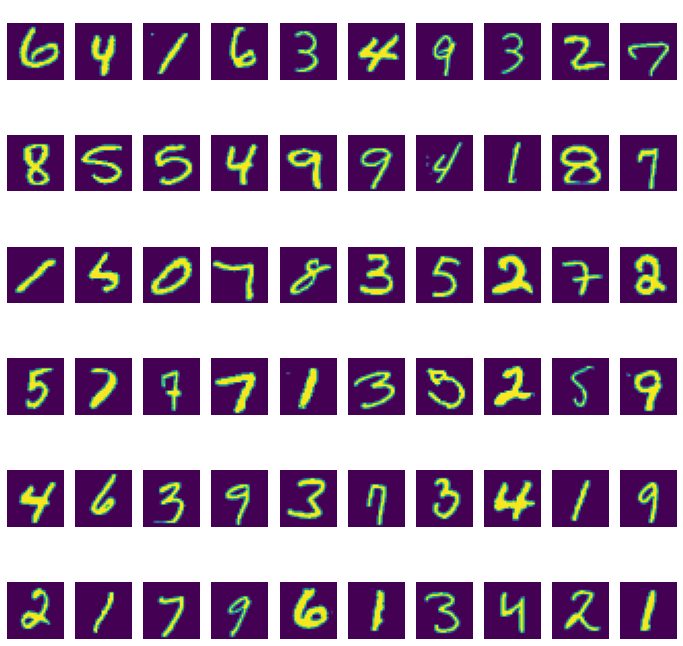

In [7]:
# visualize data in grid format

figure = plt.figure(figsize=(12,12))
num_of_images = 60

for index in range(1, num_of_images+1):
  plt.subplot(6,10,index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze())
  plt.title(labels[index].item(),color='w')

# Network with and without GBN

In [8]:
# Model Architecture - No GBN

# dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 22
        

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU() ,
            nn.Dropout(dropout_value)
        ) # output_size = 5

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value) 
        ) # output_size = 3

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        )


        # TRANSITION BLOCK 2
        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU()
        ) # output_size = 5

    

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        #x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)

        x = self.gap(x)
        x = self.convblock10(x)

        #x = self.convblock11(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,440
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1, 10,

In [9]:
# num_splits=2

class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)


In [10]:
# GBN Architecture


class Net_GBN(nn.Module):
    def __init__(self):
        super(Net_GBN, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=10,num_splits=num_splits),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=10,num_splits=num_splits),
            nn.Dropout(dropout_value)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=16,num_splits=num_splits),
            nn.Dropout(dropout_value)
        ) # output_size = 22
        

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=10,num_splits=num_splits),
            nn.Dropout(dropout_value)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=16,num_splits=num_splits),
           nn.Dropout(dropout_value)
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=16,num_splits=num_splits),
            nn.Dropout(dropout_value)
        ) # output_size = 5

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=16,num_splits=num_splits),
            nn.Dropout(dropout_value) 
        ) # output_size = 3

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        )


        # TRANSITION BLOCK 2
        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU()
        ) # output_size = 5

    

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        #x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)

        x = self.gap(x)
        x = self.convblock10(x)

        #x = self.convblock11(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net_GBN().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
              ReLU-6           [-1, 10, 24, 24]               0
    GhostBatchNorm-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,440
             ReLU-10           [-1, 16, 22, 22]               0
   GhostBatchNorm-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1, 10,

# MODULAR

In [11]:
# Modular PRogramming

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm


class Trainer():
  '''Trainer Classe '''
  
  def __init__(self,model,device,train_loader,test_loader,optimizer,epoch,schedul):
    self.model = model
    self.device= device
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.optimizer = optimizer
    self.epoch = epoch
    self.scheduler = schedul


  def train(self,l1_lambda=0, l2_lambda=0):

    self.l1_lambda = l1_lambda
    self.l2_lambda = l2_lambda

    comb_train_losses = []
    comb_train_acc    = []
    comb_test_losses  = []
    comb_test_acc     = []
    # EPOCHS = 10
    for epoch in range(self.epoch):
        
        print("EPOCH:", epoch)
        print('learning rate ', self.scheduler.get_lr())

        # trainer = Trainer(model,device,train_loader,test_loader,optimizer,epoch)

        train_ac, train_los = trainer.train_mod()
        scheduler.step()    
        test_ac, test_los = trainer.test_mod()

        comb_train_losses.extend(train_los)
        comb_train_acc.extend(train_ac)
        comb_test_losses.extend(test_los)
        comb_test_acc.extend(test_ac)
    return ((comb_train_acc,comb_train_losses),(comb_test_acc,comb_test_losses)) 

  def train_mod(self):

    train_losses = []
    train_acc = []
    
    self.model.train()
    pbar = tqdm(self.train_loader)

    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(self.device), target.to(self.device)

      # Init
      self.optimizer.zero_grad()

      # Predict
      y_pred = self.model(data)

      # Calculate loss

      criterion = F.nll_loss(y_pred, target)

      # l1 regularization
      l1_reg_loss = sum([torch.sum(abs(param)) for param in model.parameters()])

      # l2 regularization
      l2_reg_loss = sum([torch.sum(param**2) for param in model.parameters()])


      #Calculate loss (depending on which decay parameter passed, regularization is calculated. )

      loss = criterion + self.l1_lambda * l1_reg_loss + self.l2_lambda*l2_reg_loss
     
      train_losses.append(loss)

      # Backpropagation
      loss.backward()
      self.optimizer.step()

      # Update pbar-tqdm
      
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      train_acc.append(100*correct/processed)
    return (train_acc,train_losses)



  def test_mod(self):
    test_losses = []
    test_acc = []
    self.model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in self.test_loader:
            data, target = data.to(self.device), target.to(self.device)
            output = self.model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return (test_acc,test_losses)


    

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
# plt.style.use("dark_background")

def plot_metrics(train_metric,test_metric):
  (train_acc, train_losses) = train_metric
  (test_acc, test_losses) = test_metric


  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss",color='r')
  axs[1, 0].plot(train_acc[500:])
  axs[1, 0].set_title("Training Accuracy",color='r')
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss",color='r')
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy", color='r')



# Function to plot misclassified images

def plot_misclassified(model,test_loader,device):
  # Visualize the misclassified images
  model.eval()

  figure = plt.figure(figsize=(10,10))
  num_of_images = 25
  index=1

  with torch.no_grad():
    for data,target in test_loader:
      data,target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1,keepdim=True)
      act = target.view_as(pred)
      bool_vec = ~pred.eq(act) # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa

      # now extract the index number from the tensor which has 'true' 
      idx = list(np.where(bool_vec.cpu().numpy())[0])

      if idx: # if not a blank list
        idx_list = idx
        # print(data[idx_list[0]].shape)
        if index < num_of_images+1:
              
            plt.subplot(5,5,index)
            plt.axis('off')
            titl = 'act/pred : ' + str(target[idx[0]].cpu().item()) + '/' + str(pred[idx[0]].cpu().item())
            plt.imshow(data[idx[0]].cpu().numpy().squeeze()) # prints the 1st index of each batch. 
            plt.title(titl)
            index+=1



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [13]:


# # No GBN Network
# model =  Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.05)

# # GBN Network
# model2 =  Net_GBN().to(device)
# optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.05)



In [14]:
# d1 = {'NO L1&L1': [0.,0.,model],
#       'L1 Only': [1e-04,0.,model], 
#       'L2 Only': [0.,1e-04,model],
#       'L1&L2':[1e-04,1e-04,model]}

# for x in d1.keys():
#   print(d1[x][2])

# RUN ALL MODELS IN LOOP

In [15]:


# print(d1)
for x in d1.keys():
  exp_name = x
  print('\nThis model is for :',exp_name)
  l1 = d1[x][0]
  l2 = d1[x][1]
  model_name = d1[x][2]
  # modelo = d1[x][3]

  if model_name == 'model':
      
    print('\n model name:',model_name)
    model =  Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=6, gamma=0.05)
    trainer = Trainer(model,device,train_loader,test_loader,optimizer,EPOCHS,scheduler)
    train_metric, test_metric = trainer.train(l1_lambda=l1, l2_lambda=l2)

  elif model_name == 'model2':
    print('\n model name:',model_name)
    model2 =  Net_GBN().to(device)
    optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=6, gamma=0.05)
    trainer = Trainer(model2,device,train_loader,test_loader,optimizer,EPOCHS,scheduler)
    train_metric, test_metric = trainer.train(l1_lambda=l1, l2_lambda=l2)


  # save the metrics in dictionary

  metric_values[exp_name] = (train_metric, test_metric)

  # print(x,d1[x][0],d1[x][1],d1[x][2])

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]


This model is for : NO L1&L1

 model name: model
EPOCH: 0
learning rate  [0.01]


Loss=0.14140649139881134 Batch_id=468 Accuracy=89.16: 100%|██████████| 469/469 [00:14<00:00, 31.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0666, Accuracy: 9836/10000 (98.36%)

EPOCH: 1
learning rate  [0.01]


Loss=0.11176630109548569 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:14<00:00, 31.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0574, Accuracy: 9838/10000 (98.38%)

EPOCH: 2
learning rate  [0.01]


Loss=0.02320156805217266 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:14<00:00, 31.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9899/10000 (98.99%)

EPOCH: 3
learning rate  [0.01]


Loss=0.0244649276137352 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:15<00:00, 30.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9916/10000 (99.16%)

EPOCH: 4
learning rate  [0.01]


Loss=0.010932604782283306 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 30.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9917/10000 (99.17%)

EPOCH: 5
learning rate  [0.01]


Loss=0.044222552329301834 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:15<00:00, 31.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9922/10000 (99.22%)

EPOCH: 6
learning rate  [2.5e-05]


Loss=0.015920063480734825 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9933/10000 (99.33%)

EPOCH: 7
learning rate  [0.0005]


Loss=0.007312451023608446 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9932/10000 (99.32%)

EPOCH: 8
learning rate  [0.0005]


Loss=0.008586402051150799 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 30.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9934/10000 (99.34%)

EPOCH: 9
learning rate  [0.0005]


Loss=0.06782665848731995 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9935/10000 (99.35%)

EPOCH: 10
learning rate  [0.0005]


Loss=0.015859583392739296 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 31.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9937/10000 (99.37%)

EPOCH: 11
learning rate  [0.0005]


Loss=0.10766201466321945 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 30.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9938/10000 (99.38%)

EPOCH: 12
learning rate  [1.25e-06]


Loss=0.01951437257230282 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 30.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9938/10000 (99.38%)

EPOCH: 13
learning rate  [2.5e-05]


Loss=0.025401271879673004 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 30.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9935/10000 (99.35%)

EPOCH: 14
learning rate  [2.5e-05]


Loss=0.04982553794980049 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 30.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9936/10000 (99.36%)

EPOCH: 15
learning rate  [2.5e-05]


Loss=0.05333222076296806 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 30.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9935/10000 (99.35%)

EPOCH: 16
learning rate  [2.5e-05]


Loss=0.024844862520694733 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 30.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9937/10000 (99.37%)

EPOCH: 17
learning rate  [2.5e-05]


Loss=0.0058754547499120235 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 30.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9937/10000 (99.37%)

EPOCH: 18
learning rate  [6.250000000000001e-08]


Loss=0.023097975179553032 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 30.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9938/10000 (99.38%)

EPOCH: 19
learning rate  [1.25e-06]


Loss=0.001799916964955628 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 30.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9937/10000 (99.37%)

EPOCH: 20
learning rate  [1.25e-06]


Loss=0.01807803474366665 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 30.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9937/10000 (99.37%)

EPOCH: 21
learning rate  [1.25e-06]


Loss=0.00957673229277134 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 30.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9937/10000 (99.37%)

EPOCH: 22
learning rate  [1.25e-06]


Loss=0.005759556312114 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 30.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9938/10000 (99.38%)

EPOCH: 23
learning rate  [1.25e-06]


Loss=0.034389544278383255 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 30.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9935/10000 (99.35%)

EPOCH: 24
learning rate  [3.1250000000000007e-09]


Loss=0.022342504933476448 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 30.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9936/10000 (99.36%)


This model is for : L1 Only

 model name: model
EPOCH: 0
learning rate  [0.01]


Loss=0.16651558876037598 Batch_id=468 Accuracy=86.33: 100%|██████████| 469/469 [00:15<00:00, 30.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0731, Accuracy: 9804/10000 (98.04%)

EPOCH: 1
learning rate  [0.01]


Loss=0.12159541249275208 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:15<00:00, 30.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0584, Accuracy: 9832/10000 (98.32%)

EPOCH: 2
learning rate  [0.01]


Loss=0.08755876123905182 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:15<00:00, 30.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9871/10000 (98.71%)

EPOCH: 3
learning rate  [0.01]


Loss=0.11111484467983246 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:15<00:00, 30.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9904/10000 (99.04%)

EPOCH: 4
learning rate  [0.01]


Loss=0.10949969291687012 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:15<00:00, 30.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9869/10000 (98.69%)

EPOCH: 5
learning rate  [0.01]


Loss=0.07445891946554184 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:15<00:00, 30.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9883/10000 (98.83%)

EPOCH: 6
learning rate  [2.5e-05]


Loss=0.06199114769697189 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9919/10000 (99.19%)

EPOCH: 7
learning rate  [0.0005]


Loss=0.07332289218902588 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:15<00:00, 30.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9928/10000 (99.28%)

EPOCH: 8
learning rate  [0.0005]


Loss=0.08696109056472778 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:15<00:00, 30.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9934/10000 (99.34%)

EPOCH: 9
learning rate  [0.0005]


Loss=0.09213392436504364 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:15<00:00, 30.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9939/10000 (99.39%)

EPOCH: 10
learning rate  [0.0005]


Loss=0.06633872538805008 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 29.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9935/10000 (99.35%)

EPOCH: 11
learning rate  [0.0005]


Loss=0.07471375167369843 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 30.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9929/10000 (99.29%)

EPOCH: 12
learning rate  [1.25e-06]


Loss=0.08022080361843109 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 30.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9936/10000 (99.36%)

EPOCH: 13
learning rate  [2.5e-05]


Loss=0.06313315033912659 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 30.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9943/10000 (99.43%)

EPOCH: 14
learning rate  [2.5e-05]


Loss=0.0644453912973404 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 30.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9937/10000 (99.37%)

EPOCH: 15
learning rate  [2.5e-05]


Loss=0.13313372433185577 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 30.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9935/10000 (99.35%)

EPOCH: 16
learning rate  [2.5e-05]


Loss=0.06954295933246613 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9934/10000 (99.34%)

EPOCH: 17
learning rate  [2.5e-05]


Loss=0.06320299953222275 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 30.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9936/10000 (99.36%)

EPOCH: 18
learning rate  [6.250000000000001e-08]


Loss=0.07972390204668045 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 30.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9940/10000 (99.40%)

EPOCH: 19
learning rate  [1.25e-06]


Loss=0.07294296473264694 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9933/10000 (99.33%)

EPOCH: 20
learning rate  [1.25e-06]


Loss=0.0684247612953186 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9935/10000 (99.35%)

EPOCH: 21
learning rate  [1.25e-06]


Loss=0.0619039423763752 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 30.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9937/10000 (99.37%)

EPOCH: 22
learning rate  [1.25e-06]


Loss=0.08549759536981583 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:15<00:00, 30.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)

EPOCH: 23
learning rate  [1.25e-06]


Loss=0.07352586090564728 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9936/10000 (99.36%)

EPOCH: 24
learning rate  [3.1250000000000007e-09]


Loss=0.08007925003767014 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 29.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9932/10000 (99.32%)


This model is for : L2 Only

 model name: model
EPOCH: 0
learning rate  [0.01]


Loss=0.160552978515625 Batch_id=468 Accuracy=87.32: 100%|██████████| 469/469 [00:15<00:00, 29.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0644, Accuracy: 9834/10000 (98.34%)

EPOCH: 1
learning rate  [0.01]


Loss=0.058998119086027145 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:15<00:00, 29.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9862/10000 (98.62%)

EPOCH: 2
learning rate  [0.01]


Loss=0.037030890583992004 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:15<00:00, 29.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9876/10000 (98.76%)

EPOCH: 3
learning rate  [0.01]


Loss=0.08919191360473633 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:15<00:00, 29.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9889/10000 (98.89%)

EPOCH: 4
learning rate  [0.01]


Loss=0.1267813891172409 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9905/10000 (99.05%)

EPOCH: 5
learning rate  [0.01]


Loss=0.06367526203393936 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:15<00:00, 29.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9926/10000 (99.26%)

EPOCH: 6
learning rate  [2.5e-05]


Loss=0.08039357513189316 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:15<00:00, 29.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9934/10000 (99.34%)

EPOCH: 7
learning rate  [0.0005]


Loss=0.07986144721508026 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:15<00:00, 29.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)

EPOCH: 8
learning rate  [0.0005]


Loss=0.0745849460363388 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 29.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9934/10000 (99.34%)

EPOCH: 9
learning rate  [0.0005]


Loss=0.05387662723660469 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 30.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9935/10000 (99.35%)

EPOCH: 10
learning rate  [0.0005]


Loss=0.13972170650959015 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9935/10000 (99.35%)

EPOCH: 11
learning rate  [0.0005]


Loss=0.048906851559877396 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 30.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9937/10000 (99.37%)

EPOCH: 12
learning rate  [1.25e-06]


Loss=0.14846940338611603 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 29.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9936/10000 (99.36%)

EPOCH: 13
learning rate  [2.5e-05]


Loss=0.07810971140861511 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 29.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9936/10000 (99.36%)

EPOCH: 14
learning rate  [2.5e-05]


Loss=0.08683833479881287 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 29.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9935/10000 (99.35%)

EPOCH: 15
learning rate  [2.5e-05]


Loss=0.04227530211210251 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 29.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9939/10000 (99.39%)

EPOCH: 16
learning rate  [2.5e-05]


Loss=0.04152593016624451 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 29.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9941/10000 (99.41%)

EPOCH: 17
learning rate  [2.5e-05]


Loss=0.05203191936016083 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:16<00:00, 28.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9936/10000 (99.36%)

EPOCH: 18
learning rate  [6.250000000000001e-08]


Loss=0.05045013502240181 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9940/10000 (99.40%)

EPOCH: 19
learning rate  [1.25e-06]


Loss=0.06368344277143478 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 29.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9935/10000 (99.35%)

EPOCH: 20
learning rate  [1.25e-06]


Loss=0.02617870829999447 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 29.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9941/10000 (99.41%)

EPOCH: 21
learning rate  [1.25e-06]


Loss=0.039323803037405014 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 29.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9936/10000 (99.36%)

EPOCH: 22
learning rate  [1.25e-06]


Loss=0.037857264280319214 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:16<00:00, 29.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

EPOCH: 23
learning rate  [1.25e-06]


Loss=0.050808921456336975 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 29.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.37%)

EPOCH: 24
learning rate  [3.1250000000000007e-09]


Loss=0.05967143177986145 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9938/10000 (99.38%)


This model is for : L1&L2

 model name: model
EPOCH: 0
learning rate  [0.01]


Loss=0.2599529027938843 Batch_id=468 Accuracy=90.59: 100%|██████████| 469/469 [00:15<00:00, 29.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0648, Accuracy: 9830/10000 (98.30%)

EPOCH: 1
learning rate  [0.01]


Loss=0.16432338953018188 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:15<00:00, 29.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0578, Accuracy: 9838/10000 (98.38%)

EPOCH: 2
learning rate  [0.01]


Loss=0.09249341487884521 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:15<00:00, 29.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9859/10000 (98.59%)

EPOCH: 3
learning rate  [0.01]


Loss=0.11617887020111084 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:15<00:00, 29.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9895/10000 (98.95%)

EPOCH: 4
learning rate  [0.01]


Loss=0.09999121725559235 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:15<00:00, 29.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9897/10000 (98.97%)

EPOCH: 5
learning rate  [0.01]


Loss=0.08712844550609589 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9909/10000 (99.09%)

EPOCH: 6
learning rate  [2.5e-05]


Loss=0.09172641485929489 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:15<00:00, 29.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9928/10000 (99.28%)

EPOCH: 7
learning rate  [0.0005]


Loss=0.13327527046203613 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 29.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9929/10000 (99.29%)

EPOCH: 8
learning rate  [0.0005]


Loss=0.1283993124961853 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 29.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9931/10000 (99.31%)

EPOCH: 9
learning rate  [0.0005]


Loss=0.0876825675368309 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 29.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9930/10000 (99.30%)

EPOCH: 10
learning rate  [0.0005]


Loss=0.10472439229488373 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 29.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9934/10000 (99.34%)

EPOCH: 11
learning rate  [0.0005]


Loss=0.08937747776508331 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 29.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

EPOCH: 12
learning rate  [1.25e-06]


Loss=0.09649614989757538 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 29.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9932/10000 (99.32%)

EPOCH: 13
learning rate  [2.5e-05]


Loss=0.10465050488710403 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 29.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9933/10000 (99.33%)

EPOCH: 14
learning rate  [2.5e-05]


Loss=0.1154416874051094 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 29.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9930/10000 (99.30%)

EPOCH: 15
learning rate  [2.5e-05]


Loss=0.09143231064081192 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:15<00:00, 29.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9932/10000 (99.32%)

EPOCH: 16
learning rate  [2.5e-05]


Loss=0.0883454978466034 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 29.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9932/10000 (99.32%)

EPOCH: 17
learning rate  [2.5e-05]


Loss=0.08891116827726364 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 29.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

EPOCH: 18
learning rate  [6.250000000000001e-08]


Loss=0.09601954370737076 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 29.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9935/10000 (99.35%)

EPOCH: 19
learning rate  [1.25e-06]


Loss=0.08105915784835815 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:16<00:00, 29.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

EPOCH: 20
learning rate  [1.25e-06]


Loss=0.09709839522838593 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 29.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9928/10000 (99.28%)

EPOCH: 21
learning rate  [1.25e-06]


Loss=0.1670038253068924 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 29.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9933/10000 (99.33%)

EPOCH: 22
learning rate  [1.25e-06]


Loss=0.08323302865028381 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 29.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9928/10000 (99.28%)

EPOCH: 23
learning rate  [1.25e-06]


Loss=0.07789436727762222 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 29.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9934/10000 (99.34%)

EPOCH: 24
learning rate  [3.1250000000000007e-09]


Loss=0.07943864166736603 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 29.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9935/10000 (99.35%)


This model is for : GBN Only

 model name: model2
EPOCH: 0
learning rate  [0.01]


Loss=0.0823461189866066 Batch_id=468 Accuracy=92.90: 100%|██████████| 469/469 [00:16<00:00, 29.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 9857/10000 (98.57%)

EPOCH: 1
learning rate  [0.01]


Loss=0.036750733852386475 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:16<00:00, 29.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9901/10000 (99.01%)

EPOCH: 2
learning rate  [0.01]


Loss=0.054129716008901596 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:16<00:00, 28.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9877/10000 (98.77%)

EPOCH: 3
learning rate  [0.01]


Loss=0.016063597053289413 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:16<00:00, 28.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9897/10000 (98.97%)

EPOCH: 4
learning rate  [0.01]


Loss=0.013675312511622906 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:16<00:00, 27.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9910/10000 (99.10%)

EPOCH: 5
learning rate  [0.01]


Loss=0.04671141132712364 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:16<00:00, 28.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9910/10000 (99.10%)

EPOCH: 6
learning rate  [2.5e-05]


Loss=0.012618876993656158 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:16<00:00, 29.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9937/10000 (99.37%)

EPOCH: 7
learning rate  [0.0005]


Loss=0.026760781183838844 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9941/10000 (99.41%)

EPOCH: 8
learning rate  [0.0005]


Loss=0.01783699169754982 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 28.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9942/10000 (99.42%)

EPOCH: 9
learning rate  [0.0005]


Loss=0.00751141645014286 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:16<00:00, 29.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9943/10000 (99.43%)

EPOCH: 10
learning rate  [0.0005]


Loss=0.08728557080030441 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9943/10000 (99.43%)

EPOCH: 11
learning rate  [0.0005]


Loss=0.033419907093048096 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 29.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9939/10000 (99.39%)

EPOCH: 12
learning rate  [1.25e-06]


Loss=0.03615250065922737 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:16<00:00, 29.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9941/10000 (99.41%)

EPOCH: 13
learning rate  [2.5e-05]


Loss=0.05010463297367096 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:15<00:00, 29.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9941/10000 (99.41%)

EPOCH: 14
learning rate  [2.5e-05]


Loss=0.008755345828831196 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 30.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9945/10000 (99.45%)

EPOCH: 15
learning rate  [2.5e-05]


Loss=0.008332516066730022 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 30.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9943/10000 (99.43%)

EPOCH: 16
learning rate  [2.5e-05]


Loss=0.015082460828125477 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9943/10000 (99.43%)

EPOCH: 17
learning rate  [2.5e-05]


Loss=0.014218058437108994 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 30.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9941/10000 (99.41%)

EPOCH: 18
learning rate  [6.250000000000001e-08]


Loss=0.04159073531627655 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 30.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9945/10000 (99.45%)

EPOCH: 19
learning rate  [1.25e-06]


Loss=0.006275579333305359 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 30.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9941/10000 (99.41%)

EPOCH: 20
learning rate  [1.25e-06]


Loss=0.06940501183271408 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 30.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9943/10000 (99.43%)

EPOCH: 21
learning rate  [1.25e-06]


Loss=0.06760745495557785 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9944/10000 (99.44%)

EPOCH: 22
learning rate  [1.25e-06]


Loss=0.019364239647984505 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 30.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9941/10000 (99.41%)

EPOCH: 23
learning rate  [1.25e-06]


Loss=0.01779388263821602 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:15<00:00, 31.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9941/10000 (99.41%)

EPOCH: 24
learning rate  [3.1250000000000007e-09]


Loss=0.013512766920030117 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 31.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9940/10000 (99.40%)


This model is for : GBN with L1 and L2

 model name: model2
EPOCH: 0
learning rate  [0.01]


Loss=0.19758020341396332 Batch_id=468 Accuracy=92.46: 100%|██████████| 469/469 [00:15<00:00, 30.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0609, Accuracy: 9826/10000 (98.26%)

EPOCH: 1
learning rate  [0.01]


Loss=0.18440143764019012 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:15<00:00, 30.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9894/10000 (98.94%)

EPOCH: 2
learning rate  [0.01]


Loss=0.2942984104156494 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:14<00:00, 31.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9878/10000 (98.78%)

EPOCH: 3
learning rate  [0.01]


Loss=0.12173672020435333 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:14<00:00, 31.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9898/10000 (98.98%)

EPOCH: 4
learning rate  [0.01]


Loss=0.10374557226896286 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:14<00:00, 31.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9927/10000 (99.27%)

EPOCH: 5
learning rate  [0.01]


Loss=0.08265867084264755 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:15<00:00, 30.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9929/10000 (99.29%)

EPOCH: 6
learning rate  [2.5e-05]


Loss=0.083807073533535 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 31.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9943/10000 (99.43%)

EPOCH: 7
learning rate  [0.0005]


Loss=0.09535454213619232 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 31.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9941/10000 (99.41%)

EPOCH: 8
learning rate  [0.0005]


Loss=0.09825439006090164 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 31.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9939/10000 (99.39%)

EPOCH: 9
learning rate  [0.0005]


Loss=0.07421655207872391 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 31.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9943/10000 (99.43%)

EPOCH: 10
learning rate  [0.0005]


Loss=0.11969681829214096 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:15<00:00, 31.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9949/10000 (99.49%)

EPOCH: 11
learning rate  [0.0005]


Loss=0.10701284557580948 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 31.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)

EPOCH: 12
learning rate  [1.25e-06]


Loss=0.08408159017562866 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 31.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9944/10000 (99.44%)

EPOCH: 13
learning rate  [2.5e-05]


Loss=0.1379667967557907 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:14<00:00, 31.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9945/10000 (99.45%)

EPOCH: 14
learning rate  [2.5e-05]


Loss=0.1103256419301033 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 31.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9944/10000 (99.44%)

EPOCH: 15
learning rate  [2.5e-05]


Loss=0.07995046675205231 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 30.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9943/10000 (99.43%)

EPOCH: 16
learning rate  [2.5e-05]


Loss=0.10417229682207108 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 32.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9945/10000 (99.45%)

EPOCH: 17
learning rate  [2.5e-05]


Loss=0.07759671658277512 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9944/10000 (99.44%)

EPOCH: 18
learning rate  [6.250000000000001e-08]


Loss=0.08837368339300156 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 31.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9947/10000 (99.47%)

EPOCH: 19
learning rate  [1.25e-06]


Loss=0.08080894500017166 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 31.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9945/10000 (99.45%)

EPOCH: 20
learning rate  [1.25e-06]


Loss=0.07598812133073807 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)

EPOCH: 21
learning rate  [1.25e-06]


Loss=0.09738171100616455 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9944/10000 (99.44%)

EPOCH: 22
learning rate  [1.25e-06]


Loss=0.2173943966627121 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:14<00:00, 31.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9944/10000 (99.44%)

EPOCH: 23
learning rate  [1.25e-06]


Loss=0.07684998959302902 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 31.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9941/10000 (99.41%)

EPOCH: 24
learning rate  [3.1250000000000007e-09]


Loss=0.1197405532002449 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:15<00:00, 31.18it/s]



Test set: Average loss: 0.0178, Accuracy: 9943/10000 (99.43%)



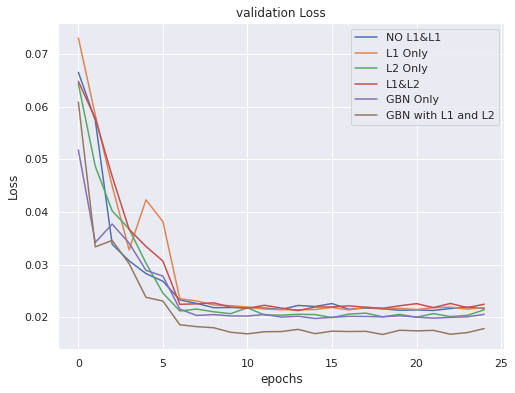

In [16]:
# plot Loss for all models

plt.figure(figsize=(8,6))
plt.title('validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
for idx,exp_name in enumerate(metric_values.keys()):
  train_metric,test_metric = metric_values[exp_name]
  train_acc,train_loss = train_metric
  test_acc,test_loss = test_metric
  plt.plot(test_loss,label='{}'.format(exp_name))
plt.legend()
plt.show()

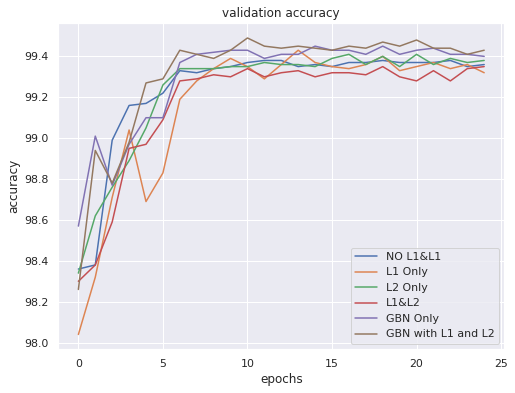

In [17]:
# plot accuracy for all models

plt.figure(figsize=(8,6))
plt.title('validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
for idx,exp_name in enumerate(metric_values.keys()):
  train_metric,test_metric = metric_values[exp_name]
  train_acc,train_loss = train_metric
  test_acc,test_loss = test_metric
  plt.plot(test_acc,label='{}'.format(exp_name))
plt.legend()
plt.show()

# Plot misclassified

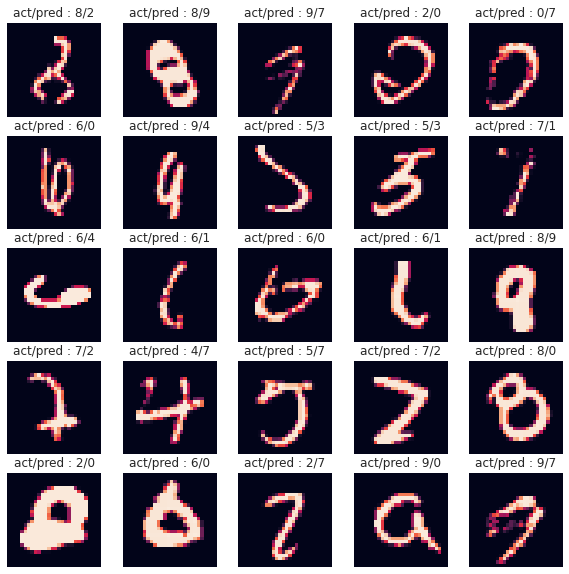

In [18]:
plot_misclassified(model2,test_loader,device)